# Regression/Classifier of Loan Amount

In [1]:
## Packages to import
from itertools import *
import numpy as np
import pandas as pd
import sys
## Install packages if need be
#!{sys.executable} -m pip install category_encoders
#!{sys.executable} -m pip install scikit-learn
#!{sys.executable} -m pip install fancyimpute
#!{sys.executable} -m pip install xgboost

#Encoders and Imputers
from category_encoders import TargetEncoder, OneHotEncoder, HashingEncoder, BinaryEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

#Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

#Plotting and visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn and models
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor

## Load Data

In [29]:
# ## Load Data
df = pd.read_csv('Finalized_Dataset.csv')
dg = df.loan_amount
df = df.drop(columns=['Unnamed: 0'])
print(df.head())
dg = dg.multiply(10**(-6))
print(dg.head())
srt = dg.sort_values()
print(srt[-20:])

   Year  loan_amount    Country                Region        Elec  \
0  1990   18000000.0     poland        eastern europe  100.000000   
1  1990  329000000.0  indonesia  asia (ex. near east)  100.000000   
2  1990  350000000.0       peru   latin amer. & carib   53.247423   
3  1990  110000000.0    algeria       northern africa   97.200000   
4  1990   25000000.0      india  asia (ex. near east)   16.958274   

         GDPpC        Lit   Gini  Stability  
0  6170.249054  90.032054  39.30     -0.418  
1  3082.082407  81.519852  31.20     -0.308  
2  3361.406815  72.116540  38.06     -0.102  
3  6916.495704  99.704750  39.50     -0.490  
4  1201.668486  48.222069  42.88     -1.024  
0     18.0
1    329.0
2    350.0
3    110.0
4     25.0
Name: loan_amount, dtype: float64
2268    1250.000000
1837    1250.000000
28      1260.000000
2059    1284.788672
1871    1300.000000
1881    1325.694574
2760    1328.118039
1744    1394.759375
2276    1443.820000
2534    1450.000000
862     1500.000000


### See datatypes and any missing values

In [3]:
## General Information about data
print(df.info())
print(df.dtypes)
print(df.Region.unique())
print('The number of countries is ',len(df.Country.unique()))
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2875 entries, 0 to 2874
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         2875 non-null   int64  
 1   loan_amount  2875 non-null   float64
 2   Country      2875 non-null   object 
 3   Region       2875 non-null   object 
 4   Elec         2875 non-null   float64
 5   GDPpC        2875 non-null   float64
 6   Lit          2875 non-null   float64
 7   Gini         2875 non-null   float64
 8   Stability    2875 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 202.3+ KB
None
Year             int64
loan_amount    float64
Country         object
Region          object
Elec           float64
GDPpC          float64
Lit            float64
Gini           float64
Stability      float64
dtype: object
['eastern europe' 'asia (ex. near east)' 'latin amer. & carib'
 'northern africa' 'near east' 'sub-saharan africa' 'oceania'
 'western europe'

### Split intro train/val/test sets

In [4]:
### Split train and test and validation (Compare some models with validation)
X_train,X_test,y_train,y_test = train_test_split(df,dg,test_size=0.20,random_state=42)
X_tt,X_val,y_tt,y_val = train_test_split(X_train,y_train,test_size=0.20,random_state=32)

## Check for correlation between variables

In [5]:
print(pd.concat([X_tt,y_tt],axis=1).corr())

                 Year  loan_amount      Elec     GDPpC       Lit      Gini  \
Year         1.000000     0.147518  0.396141  0.376681  0.376828  0.079700   
loan_amount  0.147518     1.000000  0.048949  0.078317  0.055431 -0.033417   
Elec         0.396141     0.048949  1.000000  0.475470  0.682149  0.165634   
GDPpC        0.376681     0.078317  0.475470  1.000000  0.489648  0.094287   
Lit          0.376828     0.055431  0.682149  0.489648  1.000000  0.178285   
Gini         0.079700    -0.033417  0.165634  0.094287  0.178285  1.000000   
Stability    0.219793    -0.031932  0.301658  0.393835  0.282990  0.089717   
loan_amount  0.147518     1.000000  0.048949  0.078317  0.055431 -0.033417   

             Stability  loan_amount  
Year          0.219793     0.147518  
loan_amount  -0.031932     1.000000  
Elec          0.301658     0.048949  
GDPpC         0.393835     0.078317  
Lit           0.282990     0.055431  
Gini          0.089717    -0.033417  
Stability     1.000000    -0.03

## Check Distributions of Data

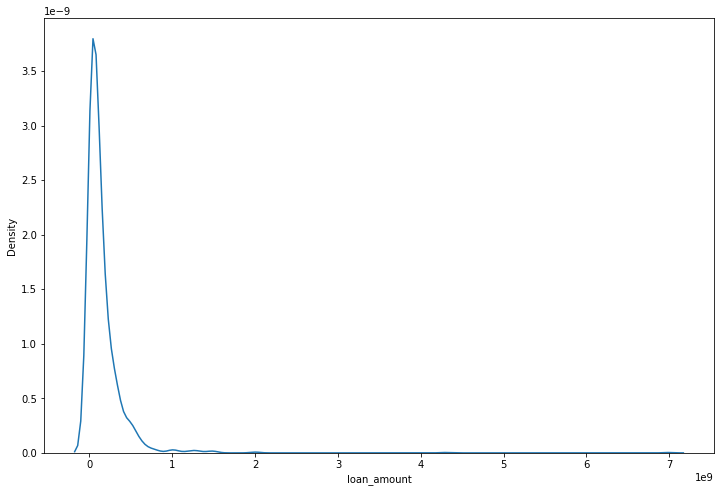

array([[<AxesSubplot:xlabel='Year', ylabel='Year'>,
        <AxesSubplot:xlabel='loan_amount', ylabel='Year'>,
        <AxesSubplot:xlabel='Elec', ylabel='Year'>,
        <AxesSubplot:xlabel='GDPpC', ylabel='Year'>,
        <AxesSubplot:xlabel='Lit', ylabel='Year'>,
        <AxesSubplot:xlabel='Gini', ylabel='Year'>,
        <AxesSubplot:xlabel='Stability', ylabel='Year'>],
       [<AxesSubplot:xlabel='Year', ylabel='loan_amount'>,
        <AxesSubplot:xlabel='loan_amount', ylabel='loan_amount'>,
        <AxesSubplot:xlabel='Elec', ylabel='loan_amount'>,
        <AxesSubplot:xlabel='GDPpC', ylabel='loan_amount'>,
        <AxesSubplot:xlabel='Lit', ylabel='loan_amount'>,
        <AxesSubplot:xlabel='Gini', ylabel='loan_amount'>,
        <AxesSubplot:xlabel='Stability', ylabel='loan_amount'>],
       [<AxesSubplot:xlabel='Year', ylabel='Elec'>,
        <AxesSubplot:xlabel='loan_amount', ylabel='Elec'>,
        <AxesSubplot:xlabel='Elec', ylabel='Elec'>,
        <AxesSubplot:xlabel='GDPpC

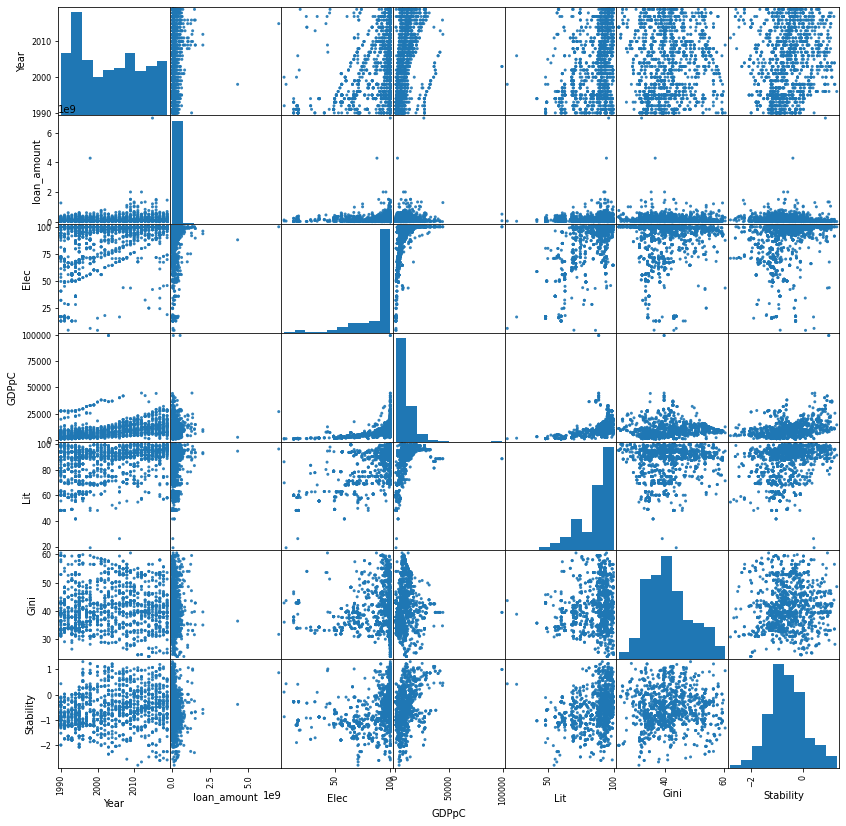

In [24]:
## Plotting to get an idea of distributions in each class (using Kernel Density Estimator)
numeric_kde = 'loan_amount' #Elec, GDPpC, Lit, Gini, Stability, loan_amount

fig = plt.figure(figsize=(12, 8))
#gs = fig.add_gridspec(3,1)
#gs.update(hspace= -0.55)

sns.kdeplot(x=numeric_kde, data = X_tt)
plt.show()
  


### Scatter plots
#plt.figure(figsize=(12,12))
#plt.scatter(X_tt.age,X_tt.income)

from pandas.plotting import scatter_matrix
#print(y_tt.head())
scatter_matrix(X_tt,figsize=(14,14),alpha=.9)

### Encoders

In [7]:
## ENCODERS
def hashing_encoding(df_feature):
    '''For state data'''
    df = df_feature.copy()
    he=HashingEncoder(n_components=8)
    return he.fit_transform(df)


def binary_encoding(df_feature):
    df = df_feature.copy()
    be= BinaryEncoder(handle_missing='return_nan',return_df=True)
    return be.fit_transform(df)

def ordinal_encoding(df_feature):
    df = df_feature.copy()
    oe = OrdinalEncoder(handle_missing='return_nan',return_df=True)
    ddf = oe.fit_transform(df)
    ddf.columns = [df_feature.name+'_enc']
    return ddf

def one_hot_encoding(df_feature):
    df = df_feature.copy()
    ohe = OneHotEncoder(handle_unknown='return_nan',return_df=True,use_cat_names=True)
    return ohe.fit_transform(df)



def encode(X):
    df = X.copy()
    enc = [df,ordinal_encoding(df['Region'])]
    df1 = pd.concat(enc,axis=1)
    X_enc = df1.drop(columns=['Region','Country','Year','loan_amount'])
    return X_enc

In [8]:
X_tt_e = encode(X_tt)
print(X_tt_e.columns)
X_tt_e.dtypes

Index(['Elec', 'GDPpC', 'Lit', 'Gini', 'Stability', 'Region_enc'], dtype='object')


Elec          float64
GDPpC         float64
Lit           float64
Gini          float64
Stability     float64
Region_enc    float64
dtype: object

### Trim or Drop Outliers

In [15]:
# ## Trimming Outliers
# def trim_outliers(X_tt_imp):
#     X = X_tt_imp.copy()
#     X['income'] = X['income'].clip(upper=X_tt_imp.income.quantile(.95),lower=X_tt_imp.income.quantile(.05))
#     X['age'] = X['age'].clip(upper=X_tt_imp.age.quantile(.95),lower=X_tt_imp.age.quantile(.05))
#     X['brand_awareness_index'] = X['brand_awareness_index'].clip(upper=X_tt_imp.brand_awareness_index.quantile(.95))
#     X['customer_loyalty_index'] = X['customer_loyalty_index'].clip(upper=X_tt_imp.customer_loyalty_index.quantile(.95),lower=-X_tt_imp.customer_loyalty_index.quantile(.95))
#     return X

## Dropping outliers (more than 3 stddevs from mean)
def drop_outliers(X_tt,y_tt):
    X = X_tt.copy()
    y = y_tt.copy()
    Xc = pd.concat([X,y],axis=1)
    Xc = Xc.drop(Xc[(Xc['loan_amount'] > X_tt.loan_amount.quantile(.997)) | (Xc['loan_amount'] < X_tt.loan_amount.quantile(.003)) | 
                    (Xc['Elec'] > X_tt.Elec.quantile(.997)) | (Xc['Elec'] < X_tt.Elec.quantile(.003)) | 
                    (Xc['GDPpC'] > X_tt.GDPpC.quantile(.997)) | (Xc['GDPpC'] < X_tt.GDPpC.quantile(.003)) | 
                    (Xc['Gini'] > X_tt.Gini.quantile(.997)) | (Xc['Gini'] < X_tt.Gini.quantile(.003)) | 
                    (Xc['Lit'] > X_tt.Lit.quantile(.997)) | (Xc['Lit'] < X_tt.Lit.quantile(.003)) | 
                    (Xc['Stability'] > X_tt.Stability.quantile(.997)) | (Xc['Stability'] < X_tt.Stability.quantile(.003))].index)
    Xd = Xc.drop(columns=['loan_amount'])
    yd = Xc.tov_6mos
    return Xd,yd

## Training data with outliers removed
X_tt_d,y_tt_d = drop_outliers(X_tt_e,y_tt)
#print(Xd.shape)
#print(yd.shape)


# Scaling

In [9]:
## MinMaxScaling not necessary for tree based methods as it is monotonic transformation
def scaling(X):    
    scaler = MinMaxScaler() 
    X1 = X.copy()
    X1['Elec'] = scaler.fit_transform(np.array(X1['Elec']).reshape(-1, 1))
    X1['GDPpC'] = scaler.fit_transform(np.array(X1['GDPpC']).reshape(-1, 1))
    X1['Lit'] = scaler.fit_transform(np.array(X1['Lit']).reshape(-1, 1))
    X1['Gini'] = scaler.fit_transform(np.array(X1['Gini']).reshape(-1, 1))
    X1['Stability'] = scaler.fit_transform(np.array(X1['Stability']).reshape(-1, 1))
    return X1

In [10]:
X_tt_scale = scaling(X_tt_d)

### Discretize Variables

In [11]:
def discretize(df,col,bins,labels):
    mx = df[col].max()
    mn = df[col].min()
    if bins == None and labels == None:
        step = (mx-mn)/10
        b = np.arange(mn,mx,step)
        df[col+'_bin']=pd.cut(x = df[col],bins = b,labels = list(range(10)))
    elif labels == None:
        l = len(bins)-1
        df[col+'_bin']=pd.cut(x = df[col],bins = bins,labels = list(range(l)))
    elif bins == None:
        step = (mx-mn)/l
        b = np.arange(mn,mx,step)
        df[col+'_bin']=pd.cut(x = df[col],bins = b, labels = labels)
    else:
        df[col+'_bin']=pd.cut(x = df[col],bins = bins,labels = labels)
    return

def bin_data(df):
    discretize(df,'Elec',bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],labels=None)
    discretize(df,'GDPpC',bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],labels=None)
    discretize(df,'Lit',bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],labels=None)
    discretize(df,'Gini',bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],labels=None)
    discretize(df,'Stability',bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],labels=None)
    return df.drop(columns=['Elec','GDPpC','Lit','Gini','Stability'])

In [12]:
## Discretize continous values
X_tt_disc = bin_data(X_tt_scale)

In [13]:
X_tt_disc.head()

,Region_enc,Elec_bin,GDPpC_bin,Lit_bin,Gini_bin,Stability_bin
2112,1.0,8,0,7,3,5
1619,2.0,9,0,9,1,5
2232,3.0,8,0,8,4,4
2861,1.0,9,0,8,5,5
2343,4.0,8,1,8,7,6


### Normalize Distr

In [14]:
def log_normalize(df,col):
    df[col] = df[col].apply(lambda x: np.log(x+1))
    return

### Boxplot to get idea of outliers
#sns.set_theme(style="whitegrid")
#ax = sns.boxplot(x=df[col]) #see how skew it is afterwards

# Prepare Validation Set

In [16]:
def transform(X_train1,X_test1):
    X_train = X_train1.copy()
    X_test = X_test1.copy()
    X_test['train'] = 0
    X_train['train'] = 1
    comb = pd.concat([X_train,X_test])
    comb_enc = encode(comb)
    comb_scale = scaling(comb_enc)
    comb_drop = drop_outliers(comb_scale)
    comb_disc = bin_data(comb_drop)
    comb_disc = comb_disc.apply(pd.to_numeric)
    X_train_enc = comb_disc[comb_disc['train'] == 1].drop(columns=['train'])
    X_test_enc = comb_disc[comb_disc['train'] == 0].drop(columns=['train'])
    return X_train_enc, X_test_enc

X_tt_enc,X_val_enc = transform(X_tt,X_val)
print(X_tt_enc.info())
print(X_tt_enc.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1840 entries, 2112 to 671
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region_enc     1840 non-null   float64
 1   Elec_bin       1375 non-null   float64
 2   GDPpC_bin      1839 non-null   float64
 3   Lit_bin        1839 non-null   float64
 4   Gini_bin       1835 non-null   float64
 5   Stability_bin  1839 non-null   float64
dtypes: float64(6)
memory usage: 100.6 KB
None
      Region_enc  Elec_bin  GDPpC_bin  Lit_bin  Gini_bin  Stability_bin
2112         1.0       8.0        0.0      7.0       3.0            5.0
1619         2.0       9.0        0.0      9.0       1.0            5.0
2232         3.0       8.0        0.0      8.0       4.0            4.0
2861         1.0       9.0        0.0      8.0       5.0            5.0
2343         4.0       8.0        1.0      8.0       7.0            6.0


# Hyperparameter Tuning

In [17]:
def model_hyperparam_tune(max_dep,alph,lamb):
    xgb_model = XGBRegressor(n_estimators = 200, max_depth=max_dep, min_child_weight=5, gamma=0, eta=0.1, subsample=.75, colsample_bytree=0.8,reg_alpha=alph,reg_lambda=lamb)
    xgb_model.fit(X_tt_enc,y_tt_d,eval_metric='rmse')
    y_pred = xgb_model.predict(X_val_enc)
    y_tt_pred = xgb_model.predict(X_tt_enc)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val,y_pred)
    print("MAE %f and RMSE %f" % (mae,rmse))
    return y_pred,y_tt_pred,rmse

max_dep = (5,8)
alph = (.05,.1,.2)
lamb = (.05,.1,.2)
M = 1000
Z = ()
for z in product(max_dep,alph,lamb):
    print(z)
    y_pred,y_tt_pred,rmse= model_hyperparam_tune(*z)
    if rmse < M:
        M = rmse
        Z = z
        
print('Best hyperparameters are\n')
print(z)
print(M)


(5, 0.05, 0.05)
MAE 119.357011 and RMSE 208.806940
(5, 0.05, 0.1)
MAE 119.013948 and RMSE 208.355563
(5, 0.05, 0.2)
MAE 118.624569 and RMSE 208.749816
(5, 0.1, 0.05)
MAE 119.356885 and RMSE 208.806820
(5, 0.1, 0.1)
MAE 118.469588 and RMSE 208.343202
(5, 0.1, 0.2)
MAE 118.625248 and RMSE 208.750406
(5, 0.2, 0.05)
MAE 119.356358 and RMSE 208.806294
(5, 0.2, 0.1)
MAE 118.469411 and RMSE 208.343130
(5, 0.2, 0.2)
MAE 118.718623 and RMSE 207.802099
(8, 0.05, 0.05)
MAE 116.503572 and RMSE 202.641758
(8, 0.05, 0.1)
MAE 115.015126 and RMSE 201.796812
(8, 0.05, 0.2)
MAE 115.735894 and RMSE 202.317222
(8, 0.1, 0.05)
MAE 115.781872 and RMSE 202.363966
(8, 0.1, 0.1)
MAE 115.527653 and RMSE 202.347403
(8, 0.1, 0.2)
MAE 115.736139 and RMSE 202.317269
(8, 0.2, 0.05)
MAE 115.970488 and RMSE 202.625060
(8, 0.2, 0.1)
MAE 115.403658 and RMSE 201.736431
(8, 0.2, 0.2)
MAE 115.297123 and RMSE 201.645419
Best hyperparameters are

(8, 0.2, 0.2)
201.6454190426779


# Train Model on whole training set

In [18]:
X_train_enc,X_test_enc = transform(X_train,X_test)

In [19]:
#Using 
d = 8
a = .2
l = .2
xgb_model = XGBRegressor(n_estimators = 200, max_depth=d, min_child_weight=5, gamma=0, eta=0.1, subsample=.75, colsample_bytree=0.8,reg_alpha=a,reg_lambda=l)
xgb_model.fit(X_train_enc,y_train,eval_metric='rmse')
y_pred = xgb_model.predict(X_test_enc)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test,y_pred)
print("MAE %f and RMSE %f" % (mae,rmse))


MAE 104.461851 and RMSE 175.129754


# Feature Importance

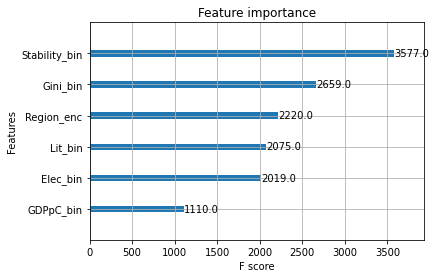

In [20]:
### Feature Importance
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [9, 9]
plt.show()


## Imputers

In [21]:
# ## Impute missing data
# def iter_impute(X):
#     impute = IterativeImputer(BayesianRidge())
#     X_imp = pd.DataFrame(impute.fit_transform(X))
#     X_imp.columns = X.columns
#     return X_imp


# # X_tt_imp = iter_impute(X_tt_enc)
# # print(X_tt_imp.shape)
# # print(X_tt_imp.columns)
# # print(X_tt_enc.shape)
# # print(X_tt_enc.columns)

